    Author: DANIEL TWENEBOAH ANYIMADU

# Semantic Nuclei Segmentation for Medical Image Analysis using U-Net: An Exploration and Evaluation

# IMPORT LIBRARIES (MODULES)

In [1]:
# libraries for exploratory data analysis (EDA)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 as cv
from PIL import Image
from glob import glob
import random

# Libraries for image data preprocessing
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

# Libraries for building U-Net 
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

import warnings
warnings.filterwarnings('ignore')

# EXPLORATORY DATA ANALYSIS (EDA)

**Handling Groundtruth:**

    Loading and visualizing the groundtruth (labels) from a csv file

In [2]:
# Define paths
main_dir_path = "C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/data-science-bowl-2018/" # Set path to main directory
train_dir_path = os.path.join(main_dir_path, "stage1_train/")                         # Set path to stage1_train
test_dir_path = os.path.join(main_dir_path, "stage1_test/")                           # Set path to stage1_test
groundtruth_path = os.path.join(main_dir_path, "stage1_train_labels.csv")             # Set path to groundtruth


# Load groundtruth data to a dataframe
groundtruth_df = pd.read_csv(groundtruth_path)
groundtruth_df.head() # Visualize the first 5 rows of the groundtruth data

,ImageId,EncodedPixels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,36269 7 36523 11 36778 13 37033 15 37288 17 37...
2,00071198d059ba7f5914a526d124d28e6d010c92466da2...,19919 6 20174 8 20429 10 20685 11 20941 12 211...
3,00071198d059ba7f5914a526d124d28e6d010c92466da2...,18671 6 18926 8 19181 9 19436 10 19691 11 1994...
4,00071198d059ba7f5914a526d124d28e6d010c92466da2...,40158 3 40413 5 40669 5 40925 5 41182 3


**Handling Training Dataset (data-science-bowl 2018)**

    Mapping "stage1_train" to "ImageId" 

In [3]:
image_file_mapping = {}; mask_file_mapping = {}

# Loop through each ImageId folder
for image_id in os.listdir(train_dir_path):
    image_folder_path = os.path.join(train_dir_path, image_id)
    images_folder = os.path.join(image_folder_path, "images")
    masks_folder = os.path.join(image_folder_path, "masks")
    
    # Get the path to the actual .png image
    image_file = glob(os.path.join(images_folder, "*.png"))
    if image_file:
        image_file_mapping[image_id] = image_file[0]
    
    # Consolidate .png subfiles into a single mask file
    mask_subfiles = glob(os.path.join(masks_folder, "*.png"))
    if mask_subfiles:
        consolidated_mask = np.maximum.reduce([cv.imread(subfile, cv.IMREAD_GRAYSCALE) for subfile in mask_subfiles])
        mask_subfile_path = os.path.join(masks_folder, "consolidated_mask.png")
        cv.imwrite(mask_subfile_path, consolidated_mask)
        mask_file_mapping[image_id] = mask_subfile_path

groundtruth_df["image_file"] = groundtruth_df["ImageId"].map(image_file_mapping)
groundtruth_df["mask_file"] = groundtruth_df["ImageId"].map(mask_file_mapping)
groundtruth_df.head()

,ImageId,EncodedPixels,image_file,mask_file
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/da...,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/da...
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,36269 7 36523 11 36778 13 37033 15 37288 17 37...,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/da...,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/da...
2,00071198d059ba7f5914a526d124d28e6d010c92466da2...,19919 6 20174 8 20429 10 20685 11 20941 12 211...,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/da...,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/da...
3,00071198d059ba7f5914a526d124d28e6d010c92466da2...,18671 6 18926 8 19181 9 19436 10 19691 11 1994...,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/da...,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/da...
4,00071198d059ba7f5914a526d124d28e6d010c92466da2...,40158 3 40413 5 40669 5 40925 5 41182 3,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/da...,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/da...


    Visualization of "data-science-bowl 2018 (image_file, mask_file)"

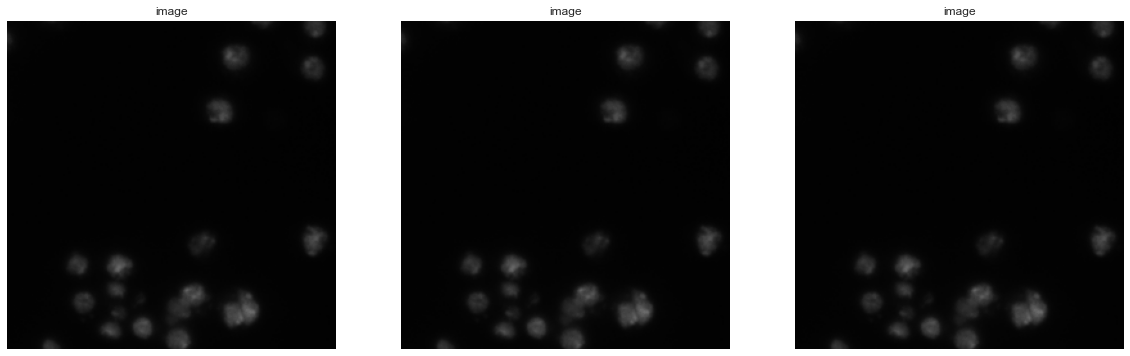

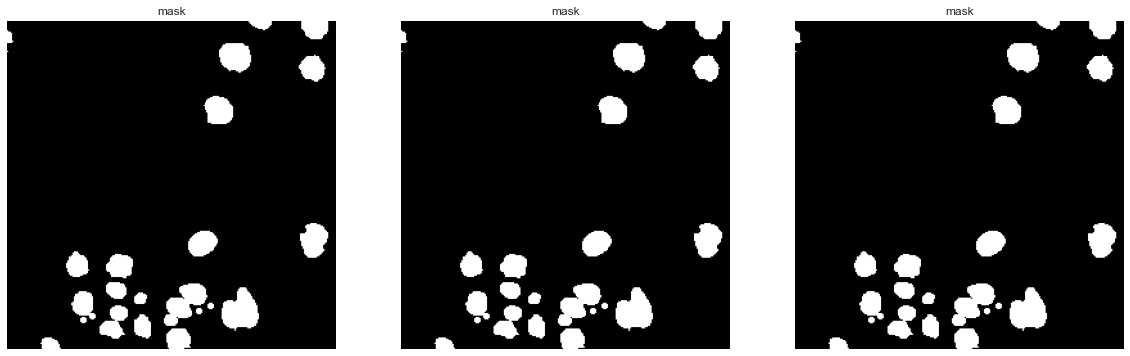

In [4]:
sns.set_style("white")

plt.figure(figsize = [20, 15]) # images
for i, image_name in enumerate(groundtruth_df["image_file"][0:3]):
    image = cv.imread(image_name)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.subplot(1, 3, i + 1); plt.imshow(image); plt.axis("off"); plt.title("image")
    
plt.show()


plt.figure(figsize = [20, 15]) # masks
for i, image_name in enumerate(groundtruth_df["mask_file"][0:3]):
    image = cv.imread(image_name)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.subplot(1, 3, i + 1); plt.imshow(image); plt.axis("off"); plt.title("mask")
    
plt.show()

# IMAGE DATA PREPROCESSING

    Image data preprocessing for semantic segmentation

In [5]:
img_height = 128; img_width = 128; img_channels = 3

# Get list of subfolders
train_ids = next(os.walk(train_dir_path))[1]
test_ids = next(os.walk(test_dir_path))[1]

    Loading training data (stage1_train) for image segmentation

In [6]:
X_train = np.zeros((len(train_ids), img_height, img_width, img_channels), dtype = np.uint8)
y_train = np.zeros((len(train_ids), img_height, img_width, 1), dtype = np.bool)

# Loop through all the train_ids
for n, id_ in tqdm(enumerate(train_ids), total = len(train_ids)):
    path = os.path.join(train_dir_path, id_)
    
    # Read and resize the image
    img = imread(os.path.join(path, "images", id_ + ".png"))[:, :, :img_channels]
    img = resize(img, (img_height, img_width), mode = "constant", preserve_range = True)
    X_train[n] = img
    
    # Initialize mask
    mask = np.zeros((img_height, img_width, 1), dtype = np.bool)
    # Loop through mask subfiles
    for mask_file in next(os.walk(os.path.join(path, "masks")))[2]:
        mask_ = imread(os.path.join(path, "masks", mask_file))
        mask_ = np.expand_dims(resize(mask_, (img_height, img_width), mode = "constant", preserve_range = True), axis = -1)
        mask = np.maximum(mask, mask_)
    
    y_train[n] = mask

100%|██████████| 670/670 [03:19<00:00,  3.36it/s]


    Loading test data (stage1_test) for image segmentation

In [7]:
# Create an empty array for test images
X_test = np.zeros((len(test_ids), img_height, img_width, img_channels), dtype = np.uint8)

# Loop through all the test_ids
for n, id_ in tqdm(enumerate(test_ids), total = len(test_ids)):
    path = os.path.join(test_dir_path, id_)
    
    # Read and resize the image
    img = imread(os.path.join(path, "images", id_ + ".png"))[:, :, :img_channels]
    img = resize(img, (img_height, img_width), mode = "constant", preserve_range = True)
    X_test[n] = img

100%|██████████| 65/65 [00:01<00:00, 55.99it/s]


# BUILD AND TRAIN U-NET ARCHITECTURE

    U-Net model implementation

In [8]:
# Function for a convolution block
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(inputs)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation = "relu", kernel_initializer = "he_normal", padding = "same")(x)
    return x

# Function for the upsampling (expanding) block
def upsample_block(inputs, conv_prev, num_filters):
    up = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides = (2, 2), padding = "same")(inputs)
    concat = tf.keras.layers.concatenate([up, conv_prev])
    conv = conv_block(concat, num_filters)
    return conv

In [9]:
inputs = tf.keras.layers.Input((128, 128, 3))         # Inputs
s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs) # Normalization

# Contraction path
c1 = conv_block(s, 16)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = conv_block(p1, 32)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = conv_block(p2, 64)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = conv_block(p3, 128)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

 # Bottleneck
c5 = conv_block(p4, 256)

# Expanding path
c6 = upsample_block(c5, c4, 128)
c7 = upsample_block(c6, c3, 64)
c8 = upsample_block(c7, c2, 32)
c9 = upsample_block(c8, c1, 16)

# Output layer
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)

In [10]:
model = tf.keras.Model(inputs = [inputs], outputs = [outputs])                          # Model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) # Compilation
model.summary()                                                                         # Summary

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

 conv2d_15 (Conv2D)             (None, 64, 64, 32)   9248        ['dropout_7[0][0]']              
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 128, 128, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 128, 128, 32  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 16  4624        ['concatenate_3[0][0]']          
                                )                                                                 
          

    Training a U-Net model with image data

In [11]:
# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose = 1, save_best_only = True)

callbacks = [tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss'),
            tf.keras.callbacks.TensorBoard(log_dir = 'logs')]

In [12]:
batch_size = 16  # number of samples processed before the model is updated
epochs = 20      # number of complete passes through the training dataset

history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_split = 0.1, callbacks = callbacks)

Epoch 1/20
38/38 [==============================] - 42s 1s/step - loss: 0.5556 - accuracy: 0.7463 - val_loss: 0.3595 - val_accuracy: 0.7771
Epoch 2/20
38/38 [==============================] - 38s 997ms/step - loss: 0.3382 - accuracy: 0.8126 - val_loss: 0.2526 - val_accuracy: 0.8913
Epoch 3/20
38/38 [==============================] - 39s 1s/step - loss: 0.1979 - accuracy: 0.9290 - val_loss: 0.1756 - val_accuracy: 0.9372
Epoch 4/20
38/38 [==============================] - 39s 1s/step - loss: 0.1584 - accuracy: 0.9438 - val_loss: 0.1294 - val_accuracy: 0.9501
Epoch 5/20
38/38 [==============================] - 39s 1s/step - loss: 0.1383 - accuracy: 0.9495 - val_loss: 0.1352 - val_accuracy: 0.9471
Epoch 6/20
38/38 [==============================] - 37s 961ms/step - loss: 0.1338 - accuracy: 0.9498 - val_loss: 0.1130 - val_accuracy: 0.9561
Epoch 7/20
38/38 [==============================] - 38s 996ms/step - loss: 0.1208 - accuracy: 0.9553 - val_loss: 0.1133 - val_accuracy: 0.9557
Epoch 8/20


    Model loss graph

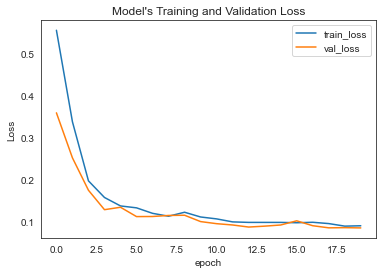

In [13]:
# Plot the training and validation loss at each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's Training and Validation Loss"); plt.ylabel('Loss'); plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

    Model acuracy graph

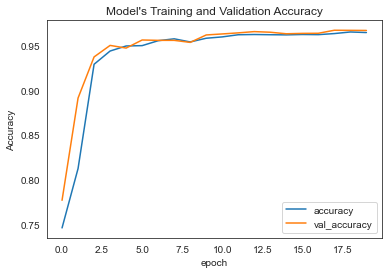

In [14]:
# Plot the training and validation accuracy at each epoch
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model's Training and Validation Accuracy"); plt.ylabel("Accuracy"); plt.xlabel("epoch")
plt.legend(["accuracy", "val_accuracy"], loc = "lower right")
plt.show()

# PREDICTIONS

    Leveraging the trained U-Net model for making predictions on the image dataset

In [15]:
# Predictions
ind = random.randint(0, len(X_train))

# Predict masks for the training, validation, and test data
pred_tr = model.predict(X_train[ : int(X_train.shape[0]*0.9)], verbose = 1)
pred_vl = model.predict(X_train[int(X_train.shape[0]*0.9) : ], verbose = 1)
pred_ts = model.predict(X_test, verbose = 1)

# Threshold predictions to convert to binary masks
tpred_tr = (pred_tr > 0.5).astype(np.uint8)
tpred_vl = (pred_vl > 0.5).astype(np.uint8)
tpred_ts = (pred_ts > 0.5).astype(np.uint8)

3/3 [==============================] - 1s 166ms/step


    Function to display images (input image, groundtruth image, predicted image)

In [16]:
# Function to display images
def display_images(image, mask, pred_mask):
    plt.figure(figsize = (15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image); plt.title("Input Image"); plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask); plt.title("Ground Truth Mask"); plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask); plt.title("Predicted Mask"); plt.axis("off")
    
    plt.show()

**Training Image:**

    Visually comparing the input image, the actual ground truth mask, and the predicted mask

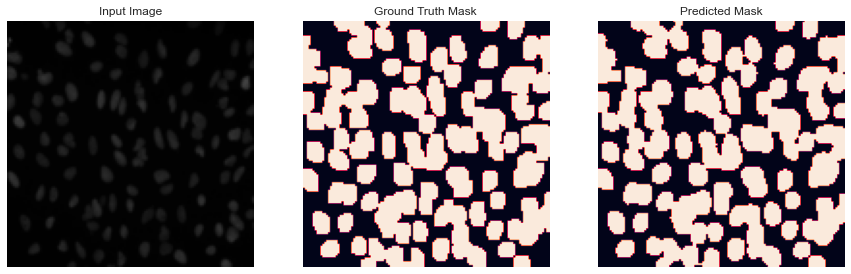

In [17]:
# Select a random index from the training (threshold) set
idx = random.randint(0, len(tpred_tr))

# Display the images
display_images(X_train[idx], np.squeeze(y_train[idx]), np.squeeze(tpred_tr[idx]))

**Validation Image:**

    Visually comparing the input image, the actual ground truth mask, and the predicted mask

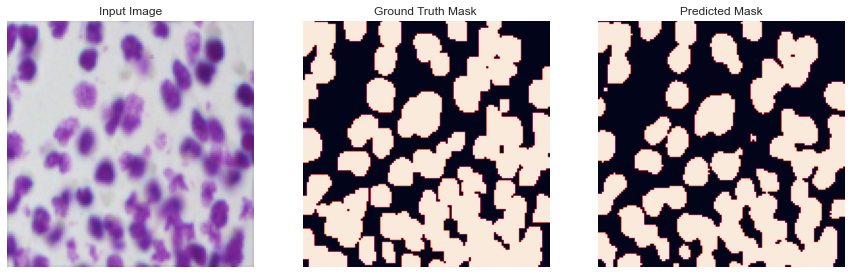

In [18]:
idx = random.randint(0, len(tpred_vl))       # Select a random index from the validation (threshold) set
val_data_start = int(X_train.shape[0] * 0.9) # Calculate the index from where validation data starts

# Display the images
display_images(X_train[val_data_start:][idx], np.squeeze(y_train[val_data_start:][idx]), np.squeeze(tpred_vl[idx]))

# EVALUATION PERFORMANCE

    Function to calculate iou (intersection over union)

In [19]:
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

    Function to calculate mAP (mean average precision)

In [20]:
def calculate_average_precision(y_true, y_pred):
    thresholds = np.arange(0.5, 1.0, 0.05)
    precisions = []
    
    for threshold in thresholds:
        iou_scores = [calculate_iou(y_true[i], y_pred[i]) > threshold for i in range(len(y_true))]
        tp = np.sum(iou_scores)
        fp = len(y_true) - tp
        precision = tp / (tp + fp) if tp + fp > 0 else 0
        precisions.append(precision)
    
    average_precision = np.mean(precisions)
    return average_precision

mAP = calculate_average_precision(y_train[val_data_start:], tpred_vl)
print("Mean Average Precision (mAP):", mAP)

Mean Average Precision (mAP): 0.7746268656716417


    Evaluation metrics on validation dataset

In [21]:
iou_scores = [calculate_iou(y_train[val_data_start:][i], tpred_vl[i]) for i in range(len(y_train[val_data_start:]))]
precision_scores = [calculate_average_precision([y_train[val_data_start:][i]], [tpred_vl[i]]) for i in range(len(y_train[val_data_start:]))]
mAP = calculate_average_precision(y_train[val_data_start:], tpred_vl)
accuracy_scores = [np.mean(y_train[val_data_start:][i] == tpred_vl[i]) for i in range(len(y_train[val_data_start:]))]

print("IoU scores:", np.mean(iou_scores))
print("precision scores:", np.mean(precision_scores))
print("Mean Average Precision (mAP):", mAP)
print("accuracy scores:", np.mean(accuracy_scores))

IoU scores: 0.8624112663304454
precision scores: 0.7746268656716417
Mean Average Precision (mAP): 0.7746268656716417
accuracy scores: 0.9667859433302238
